# Import libraries and set CSV directory

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
# import os
# import gzip

data_dir = "./mimic/mimic-iii-clinical-database-1.4"

## Set individual dataframes

In [3]:
patients_df = pd.read_csv(data_dir + str('/') + 'PATIENTS.csv')
admissions_df = pd.read_csv(data_dir + str('/') + 'ADMISSIONS.csv')
diagnoses_df = pd.read_csv(data_dir + str('/') + 'DIAGNOSES_ICD.csv')
icu_stays_df = pd.read_csv(data_dir + str('/') + 'ICUSTAYS.csv')
services_df = pd.read_csv(data_dir + str('/') + 'SERVICES.csv')
transfers_df = pd.read_csv(data_dir + str('/') + 'TRANSFERS.csv')
prescriptions_df = pd.read_csv(data_dir + str('/') + 'PRESCRIPTIONS.csv')
diagnoses_labels_df = pd.read_csv(data_dir + str('/') + 'D_ICD_DIAGNOSES.csv')

microbiology_events_df = pd.read_csv(data_dir + str('/') + 'MICROBIOLOGYEVENTS.csv')  

/var/folders/wd/pkw1ts416gsg2fjyp1rgznqc0000gn/T/ipykernel_12230/929434285.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions_df = pd.read_csv(data_dir + str('/') + 'PRESCRIPTIONS.csv')


In [4]:
# print('======================patients=====================')
# patients.info()
# print('======================admissions=====================')
# admissions.info()
# print('======================diagnoses=====================')
# diagnoses.info()
# print('======================icu_stays=====================')
# icu_stays.info()
# print('=====================services=====================')
# services.info()
# print('======================transfers=====================')
# transfers.info() 
# print('======================prescriptions=====================')
# prescriptions.info()
# print('======================diagnose_labels=====================')
# diagnoses_labels.info()

## Calculate patient age

In [5]:
from datetime import datetime

# Calculate age function
def calculate_age(dob, dod):
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    if pd.isna(dod):
        return None
    dod_date = datetime.strptime(dod, "%Y-%m-%d %H:%M:%S")
    age = (dod_date - dob_date).days // 365
    return age

# Apply calculate_age function to create "age" column
patients_df['AGE'] = patients_df.apply(lambda row: calculate_age(row['DOB'], row['DOD']), axis=1)

# Filter out rows with age greater than or equal to 120
filtered_patients_df = patients_df[patients_df['AGE'] < 120]

# Display the updated DataFrame
# print(filtered_patients_df.head())

## ICU stays & prescriptions table

In [6]:
# Merge ICU stays and prescriptions data on subject_id and hadm_id

prescriptions_df.head()

icu_presc_merged_data = pd.merge(icu_stays_df, prescriptions_df, on=['SUBJECT_ID'])


## Create bar plot for frequent prescriptions

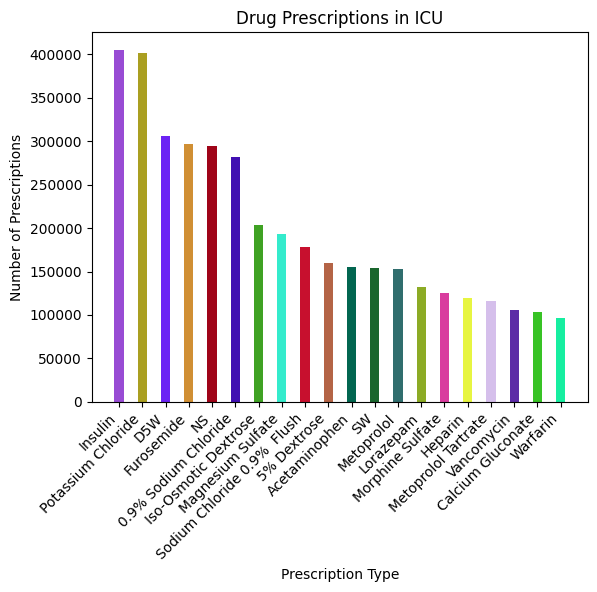

In [7]:
# Calculate unique values and their counts
unique_values, counts = np.unique(icu_presc_merged_data['DRUG'], return_counts=True)

# Sort by counts in descending order
sorted_indices = np.argsort(-counts)
sorted_values = unique_values[sorted_indices]

# Get the top 20 most frequent prescriptions
frequent_prescriptions = sorted_values[:20]

# Get the number of occurrences for the top 20 most frequent prescriptions
occurrences = icu_presc_merged_data['DRUG'].value_counts()
top_20_occurrences = occurrences[frequent_prescriptions]

# Create a list of random colors
colors = np.random.rand(len(unique_values), 3)

# creating the bar plot
plt.bar(frequent_prescriptions, top_20_occurrences, color=colors, 
        width = 0.4)

plt.xlabel("Prescription Type")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Prescriptions")
plt.title("Drug Prescriptions in ICU")

plt.show()

## Most frequent hours for ICU admissions/discharges

In [8]:
# Datetime conversion
# icu_stays_df['hour_in_time'] = pd.to_datetime(icu_stays_df['intime']).dt.hour
# icu_stays_df['hour_out_time'] = pd.to_datetime(icu_stays_df['outtime']).dt.hour

# common_in_times = icu_stays_df['hour_in_time'].value_counts()
# common_in_times = common_in_times.sort_index()  # Sort by hour of day
# hour_in_time = pd.Series(common_in_times, index=np.arange(24), name='hour_in_time')

# common_out_times = icu_stays_df['hour_out_time'].value_counts()
# common_out_times = common_out_times.sort_index()  # Sort by hour of day
# hour_out_time = pd.Series(common_out_times, index=np.arange(24), name='hour_out_time')

# # Combine the data into a single DataFrame
# data = pd.DataFrame({
#     "Hour": np.arange(24),
#     "In Time": hour_in_time,
#     "Out Time": hour_out_time
# })

# # Melt the Dataframe for Seaborn compatibility
# # Keeps Hour column as-is (it won’t be melted)
# # Names column for original column names (In Time and Out Time) to Type
# # Names column for corresponding values from (In Time and Out Time) to Count
# data_melted = data.melt(id_vars="Hour", var_name="Time Type", value_name="Count")

# # Plot the data using Seaborn
# plt.figure(figsize=(12, 6))
# sns.barplot(data=data_melted, x="Hour", y="Count", hue="Time Type", alpha=0.7, palette=["blue", "orange"])

# # Customize the plot
# plt.xlabel("Hour of Day")
# plt.ylabel("Number of Occurrences")
# plt.title("Overlapping Hourly ICU Addmission/Discharges")
# plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.legend(title="Data Sources")    

# # Show the plot
# plt.show()

## Common Diagnoses for Men

/var/folders/wd/pkw1ts416gsg2fjyp1rgznqc0000gn/T/ipykernel_12230/850942297.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



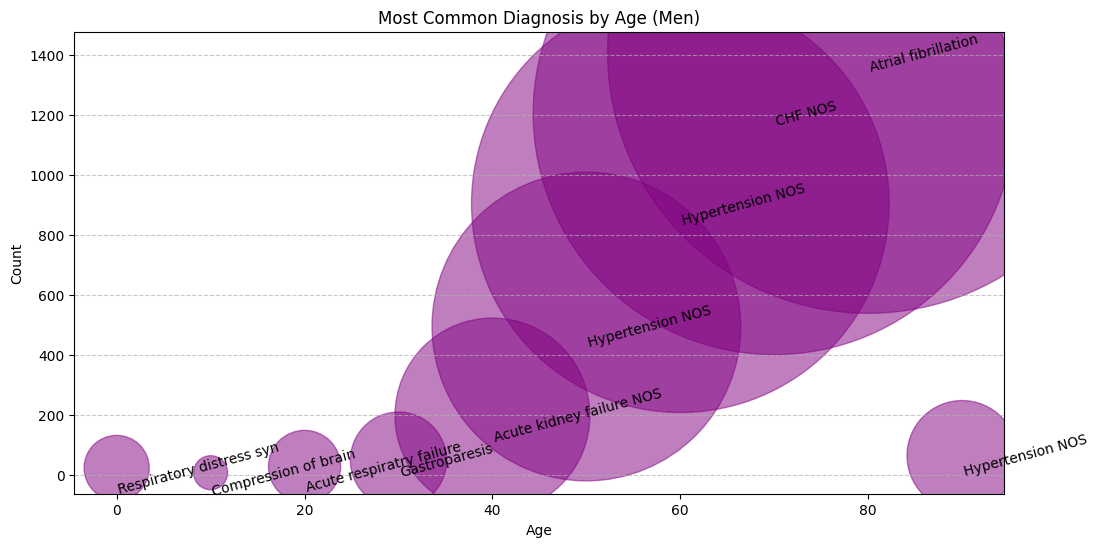

In [ ]:
# Get labels for diagnoses
merged_diagnoses_data = pd.merge(diagnoses_df, diagnoses_labels_df, on='ICD9_CODE')
merged_patient_diag_data = pd.merge(filtered_patients_df, merged_diagnoses_data, on='SUBJECT_ID')   

# Filter out female patients
male_patients_df = merged_patient_diag_data[merged_patient_diag_data['GENDER'] == 'M']

# For convenience, create a smaller df with only the age and short_title columns
male_patients_shortened_df = male_patients_df[['AGE', 'SHORT_TITLE']]

# Group by AGE decade
male_patients_shortened_df['AGE_DECADE'] = (male_patients_shortened_df['AGE'] // 10) * 10

# Find the most common SHORT_TITLE per decade
most_common_per_decade = (
    male_patients_shortened_df.groupby(['AGE_DECADE'])['SHORT_TITLE']
    .value_counts()  # Count occurrences of each title
    .groupby(level=0)  # Group by 'age'
    .head(1)  # Get the most common title per age
    .reset_index(name='count')  # Reset index and rename the count column
)

most_common_per_decade_sorted = most_common_per_decade.sort_values(by='count', ascending=False)
most_common_per_decade_sorted.head()

# Create sequence of top 10 most common diagnoses
top_10_diagnoses = most_common_per_decade_sorted['SHORT_TITLE'].value_counts().index[:10]

# Show the result
most_common_per_decade_sorted = most_common_per_decade_sorted[:10]

plt.figure(figsize=(12, 6))

# Scatter plot for bubbles
plt.scatter(
    most_common_per_decade_sorted['AGE_DECADE'], 
    most_common_per_decade_sorted["count"], 
    s=most_common_per_decade_sorted["count"] * 100, 
    alpha=0.5, 
    color="purple"
)

# Annotate each bubble with dynamic font size and a minimum size
for i, txt in enumerate(most_common_per_decade_sorted['SHORT_TITLE']):
    # font_size = max(most_common_per_decade_sorted["count"].iloc[i] * 2, 10)  # Ensure a minimum font size of 10
    plt.annotate(
        txt, 
        (most_common_per_decade_sorted['AGE_DECADE'].iloc[i], most_common_per_decade_sorted["count"].iloc[i]), 
        rotation=15,  # Rotate text by 45 degrees
        ha='left',   # Align text
        va='center'  # Align text
    )

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Most Common Diagnosis by Age (Men)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [128]:
male_patients_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,AGE,ROW_ID_x,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y,SHORT_TITLE,LONG_TITLE
17,244,261,M,2025-08-04 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,1,76.0,3172,118523,1.0,4210,4408,Ac/subac bact endocard,Acute and subacute bacterial endocarditis
18,244,261,M,2025-08-04 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,1,76.0,3173,118523,2.0,4280,4473,CHF NOS,"Congestive heart failure, unspecified"
19,244,261,M,2025-08-04 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,1,76.0,3174,118523,3.0,42731,4462,Atrial fibrillation,Atrial fibrillation
20,244,261,M,2025-08-04 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,1,76.0,3175,118523,4.0,42732,4463,Atrial flutter,Atrial flutter
21,244,261,M,2025-08-04 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00,1,76.0,3176,118523,5.0,2639,1642,Protein-cal malnutr NOS,Unspecified protein-calorie malnutrition


## Admission Types for Women

In [10]:
# Admission trends in female patients
patient_admission_df = patients_df.merge(admissions_df, on='SUBJECT_ID')

# Isolate female patients
female_patients_df = patient_admission_df[patient_admission_df['GENDER'] == 'F']
# Find admission counts for women
admissions_by_type = female_patients_df['ADMISSION_TYPE'].value_counts().reset_index()
admissions_by_type.columns = ['ADMISSION_TYPE', 'ADMISSIONS_BY_TYPE']

fig = px.pie(
    admissions_by_type, values='ADMISSIONS_BY_TYPE', 
    names='ADMISSION_TYPE', 
    title='Frequent Admission Types (Women)',
    hole=0.4
)

fig.show()

## Organism Sentsitivity to Treatment

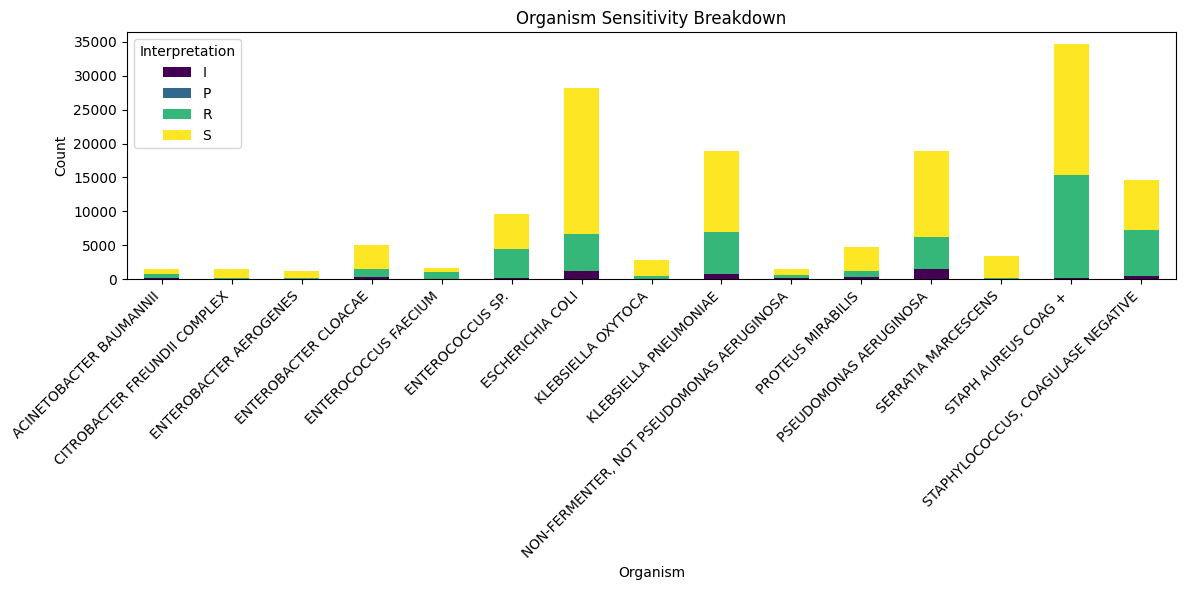

In [ ]:
patient_microbio_df = filtered_patients_df.merge(microbiology_events_df, on='SUBJECT_ID')

# Count interpretations by organism
interpretation_counts = patient_microbio_df.groupby(['ORG_NAME', 'INTERPRETATION']).size().unstack(fill_value=0)

# Cutoff for the number of interpretations to display
interpretation_counts = interpretation_counts[interpretation_counts.sum(axis=1) > 1000]

# Plot a stacked bar chart
interpretation_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Organism Sensitivity Breakdown")
plt.xlabel("Organism")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.legend(title="Interpretation")
plt.tight_layout()
plt.show()

In [ ]:

# Filter data for organisms
ecoli_data = patient_microbio_df[patient_microbio_df['org_name'] == 'ESCHERICHIA COLI']
staph_data = patient_microbio_df[patient_microbio_df['org_name'] == 'STAPH AUREUS COAG +'] 
proteus_data = patient_microbio_df[patient_microbio_df['org_name'] == 'PROTEUS MIRABILIS'] 

# Group by date of death and count the number of cases
ecoli_trends = ecoli_data.groupby('dod')['org_name'].count()
staph_trends = staph_data.groupby('dod')['org_name'].count()
proteus_trends = proteus_data.groupby('dod')['org_name'].count()

# Clean up date format
ecoli_trends.index = pd.to_datetime(ecoli_trends.index).strftime('%m-%d-%Y')
staph_trends.index = pd.to_datetime(staph_trends.index).strftime('%m-%d-%Y') 
proteus_trends.index = pd.to_datetime(proteus_trends.index).strftime('%m-%d-%Y')     

# # Plot a time series
plt.figure(figsize=(12, 6))
# plot the organism trends data
plt.plot(ecoli_data.index, ecoli_data.values, color="blue")
plt.plot(staph_data.index, staph_data.values, color="red")
plt.plot(proteus_data.index, proteus_data.values, color="green")

# plt.plot(infection_trends.index, infection_trends.values, color="red")
plt.title("Number of Infections Over Time")
plt.xlabel("Date of Death")
plt.ylabel("Number of Cases")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

KeyError: 'org_name'

## Antibiotic Resistence Heatmap

/var/folders/wd/pkw1ts416gsg2fjyp1rgznqc0000gn/T/ipykernel_12230/3021766746.py:24: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



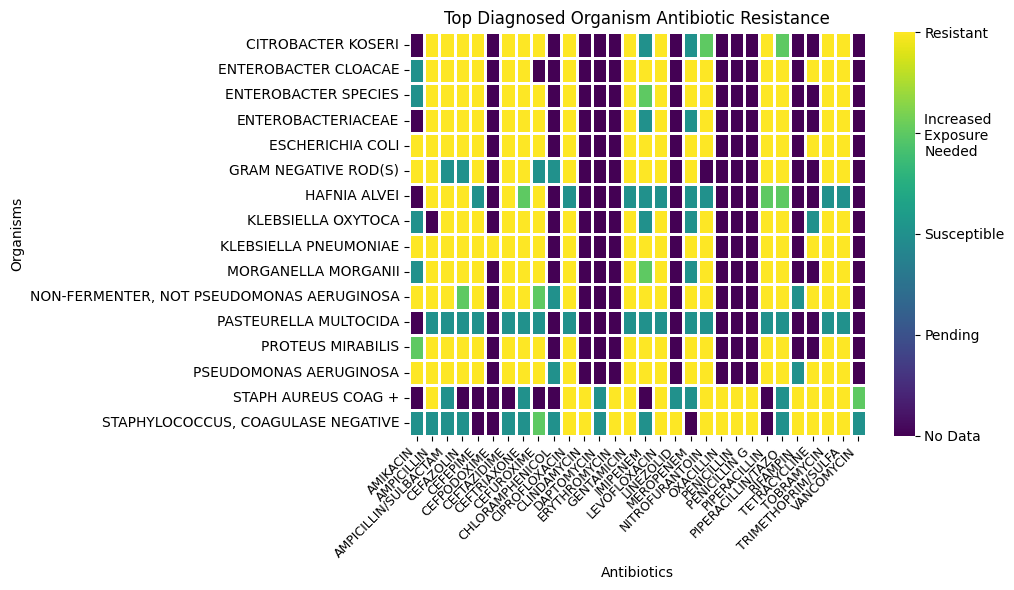

In [ ]:

# Replace NaN values with 0
microbiology_events_df['INTERPRETATION'] = microbiology_events_df['INTERPRETATION'].replace('NaN', 0)

# Step 1: Define priority mapping for interpretation (NaN has the lowest priority)
priority_mapping = {"R": 4, "I": 3, "S": 2, "P": 1, np.nan: 0}
microbiology_events_df['PRIORITY'] = microbiology_events_df['INTERPRETATION'].map(priority_mapping)

# Step 2: Resolve duplicates (if any) by keeping the highest priority interpretation
priority_data = microbiology_events_df.sort_values('PRIORITY', ascending=False).drop_duplicates(subset=['ORG_NAME', 'AB_NAME'])

# Sort by ab_name in ascending order & keep the most common organisms
priority_data = priority_data.sort_values('AB_NAME').reset_index(drop=True)
pd_filtered = priority_data.groupby('ORG_NAME').filter(lambda x: len(x) >= 18)

# Step 3: Pivot the priority_data to create a heatmap-ready table
pivot = pd_filtered.pivot(index='ORG_NAME', columns='AB_NAME', values='INTERPRETATION')
pivot = pivot.drop(pivot.columns[0], axis=1)

# Step 4: Define color mapping, including NaN
color_map = {np.nan: 0.0, "P": 1.0, "S": 2.0, "I": 3.0, "R": 4.0}  # NaN mapped to white
# Ensure NaN is handled in the pivot table when applying colors
heatmap_colors = pivot.applymap(lambda x: color_map.get(x, 0.0))
heatmap_colors.head()

# setting the parameter values 
linewidths = 1
linecolor = "white"

# Step 5: Plot the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    heatmap_colors, 
    cmap="viridis", 
    linewidths=linewidths, 
    linecolor=linecolor
)

# Customize the colorbar
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3, 4])
c_bar.set_ticklabels(['No Data', 'Pending', 'Susceptible', 'Increased \nExposure \nNeeded', 'Resistant'])

# Add a title and axis labels
plt.title("Top Diagnosed Organism Antibiotic Resistance")
plt.xlabel("Antibiotics")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.ylabel("Organisms")
plt.tight_layout()
plt.show()


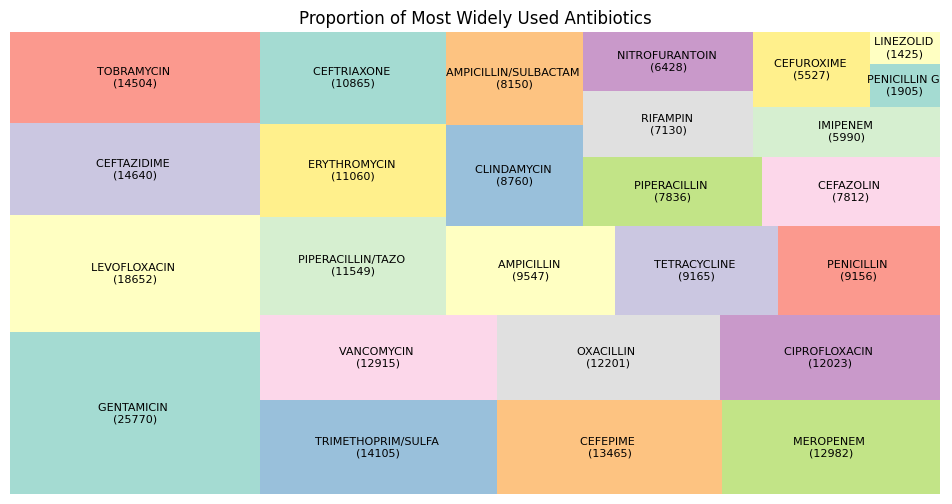

In [119]:
import squarify

# Prepare data for treemap
antibiotic_counts = microbiology_events_df["AB_NAME"].value_counts()
# Only if antibiotic_counts is higher than 1000
antibiotic_counts = antibiotic_counts[antibiotic_counts > 1000]
# Create labels for the treemap
labels = [f"{antibiotic} \n({count})" for antibiotic, count in zip(antibiotic_counts.index, antibiotic_counts.values)]

# Plot the treemap
plt.figure(figsize=(12, 6))
squarify.plot(
    sizes=antibiotic_counts.values, 
    label=labels, 
    alpha=0.8, 
    color=sns.color_palette("Set3", len(labels)),
    text_kwargs={'fontsize': 8, 'rotation': 0}
)
plt.title("Proportion of Most Widely Used Antibiotics")
plt.axis("off")
plt.show()